In [90]:
import torch
import torch.optim as optim
import random

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import transforms
from torchinfo import summary

from src.datasets import IrmaDataset
from src.transforms import MinMaxScaler, Sobel, Laplacian, GammaCorrection, HistogramEqualizer
from src.models import VAE, PVAE
from src.utils.model_utils import train_val_split, get_latent, predict
from src.utils.visualization import (
    plot_reconstructions,
    plot_2d,
    sample_images,
    plot_history,
    
)
from src.utils.training_funcs import (
    train,
    validate,
    pred_kl_reconstruction_loss,
    kl_reconstruction_loss,
    get_metrics_str,
    pred_loss,
)

In [2]:
torch.backends.cudnn.benchmark = True
batch_size = 32
torch.cuda.empty_cache()

In [3]:
def getKFoldsIdxs(ds_length, folds=5, randomize=True, random_state=42):
    fold_size = ds_length // folds
    idxs = list(range(ds_length))
    if randomize:
        random.Random(random_state).shuffle(idxs)
    return [(idxs[f*fold_size:(f+1)*fold_size]) for f in range(folds)]

In [4]:
folds = 4
k_folds = getKFoldsIdxs(5024, folds, randomize=True, random_state=7)

# Simple

In [5]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

In [6]:
def vae_builder():
    return VAE(
        latent_dim=64,
        n_channels=1,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def pvae_builder():
    return PVAE(
        latent_dim=64,
        n_classes=4,
        n_channels=1,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        pred_layers=[128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def predictor_builder():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 64),
        torch.nn.GELU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(-1)
    )

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

def run_model(latent_model, train_dl, test_dl, loss):
    model_results = {}
    
    latent_model.to(device)
    optimizer = optim.Adam(latent_model.parameters())

    model_results['hist'] = train(latent_model, optimizer, train_dl, test_dl, epochs, loss)
    model_results['metrics'] = validate(latent_model, test_dl, loss)

    train_latent, train_labels = get_latent(latent_model, train_dl)
    latent, labels = get_latent(latent_model, test_dl)

    train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
    latent, labels = latent.astype('float32'), labels.astype('int64')

    latent_train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
    latent_train_dl = DataLoader(latent_train_ds, batch_size, shuffle=True)

    latent_test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
    latent_test_dl = DataLoader(latent_test_ds, batch_size)

    pred_model = predictor_builder()
    pred_model.to(device)

    optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)

    model_results['pred_hist'] = train(pred_model, optimizer, latent_train_dl, latent_test_dl, 64, pred_loss)
    model_results['pred_metrics'] = validate(pred_model, latent_test_dl, pred_loss)

    model_results['pred_results'] = predict(pred_model, latent_test_dl, return_class=True)

    return model_results

results = []

for f in range(len(k_folds)):
    fold_results = {}

    test_fold = k_folds[f]
    train_fold = []
    for i in range(len(k_folds)): 
        if i != f: 
            for e in k_folds[i]: train_fold.append(e)
    # train_fold.sort()
    # break

    train_dl = DataLoader(Subset(dataset, train_fold), batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(Subset(dataset, test_fold), batch_size=batch_size)

    train_model = vae_builder()
    torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, kl_reconstruction_loss)
    fold_results['vae'] = {'model': train_model, **model_result}
    
    train_model = pvae_builder()
    # torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, pred_kl_reconstruction_loss)
    fold_results['pvae'] = {'model': train_model, **model_result}

    results.append(fold_results)

[epoch: 1] train_loss: 20.0908 - train_rec_loss: 20.0553 - train_kl_loss: 0.0355 - val_loss: 3.2919 - val_rec_loss: 3.2386 - val_kl_loss: 0.0532
[epoch: 2] train_loss: 2.6524 - train_rec_loss: 2.5942 - train_kl_loss: 0.0582 - val_loss: 2.4951 - val_rec_loss: 2.4453 - val_kl_loss: 0.0498
[epoch: 3] train_loss: 2.3658 - train_rec_loss: 2.3125 - train_kl_loss: 0.0533 - val_loss: 2.2402 - val_rec_loss: 2.1838 - val_kl_loss: 0.0564
[epoch: 4] train_loss: 2.0953 - train_rec_loss: 2.0402 - train_kl_loss: 0.0552 - val_loss: 1.9270 - val_rec_loss: 1.8702 - val_kl_loss: 0.0568
[epoch: 5] train_loss: 1.8448 - train_rec_loss: 1.7870 - train_kl_loss: 0.0578 - val_loss: 1.9071 - val_rec_loss: 1.8508 - val_kl_loss: 0.0564
[epoch: 6] train_loss: 1.7989 - train_rec_loss: 1.7425 - train_kl_loss: 0.0564 - val_loss: 1.7464 - val_rec_loss: 1.6886 - val_kl_loss: 0.0578
[epoch: 7] train_loss: 1.6863 - train_rec_loss: 1.6280 - train_kl_loss: 0.0583 - val_loss: 1.7723 - val_rec_loss: 1.7058 - val_kl_loss: 0.06

In [8]:
torch.save(results, 'results/simple.pt')

# Sobel

In [9]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Sobel(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

In [10]:
def vae_builder():
    return VAE(
        latent_dim=64,
        n_channels=2,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def pvae_builder():
    return PVAE(
        latent_dim=64,
        n_classes=4,
        n_channels=2,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        pred_layers=[128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def predictor_builder():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 64),
        torch.nn.GELU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(-1)
    )

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

def run_model(latent_model, train_dl, test_dl, loss):
    model_results = {}
    
    latent_model.to(device)
    optimizer = optim.Adam(latent_model.parameters())

    model_results['hist'] = train(latent_model, optimizer, train_dl, test_dl, epochs, loss)
    model_results['metrics'] = validate(latent_model, test_dl, loss)

    train_latent, train_labels = get_latent(latent_model, train_dl)
    latent, labels = get_latent(latent_model, test_dl)

    train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
    latent, labels = latent.astype('float32'), labels.astype('int64')

    latent_train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
    latent_train_dl = DataLoader(latent_train_ds, batch_size, shuffle=True)

    latent_test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
    latent_test_dl = DataLoader(latent_test_ds, batch_size)

    pred_model = predictor_builder()
    pred_model.to(device)

    optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)

    model_results['pred_hist'] = train(pred_model, optimizer, latent_train_dl, latent_test_dl, 64, pred_loss)
    model_results['pred_metrics'] = validate(pred_model, latent_test_dl, pred_loss)

    model_results['pred_results'] = predict(pred_model, latent_test_dl, return_class=True)

    return model_results

results = []

for f in range(len(k_folds)):
    fold_results = {}

    test_fold = k_folds[f]
    train_fold = []
    for i in range(len(k_folds)): 
        if i != f: 
            for e in k_folds[i]: train_fold.append(e)
    # train_fold.sort()
    # break

    train_dl = DataLoader(Subset(dataset, train_fold), batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(Subset(dataset, test_fold), batch_size=batch_size)

    train_model = vae_builder()
    torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, kl_reconstruction_loss)
    fold_results['vae'] = {'model': train_model, **model_result}
    
    train_model = pvae_builder()
    # torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, pred_kl_reconstruction_loss)
    fold_results['pvae'] = {'model': train_model, **model_result}

    results.append(fold_results)
    torch.save(results, 'results/sobel.pt')

[epoch: 1] train_loss: 12.4844 - train_rec_loss: 12.4651 - train_kl_loss: 0.0192 - val_loss: 4.0390 - val_rec_loss: 4.0141 - val_kl_loss: 0.0249
[epoch: 2] train_loss: 3.4171 - train_rec_loss: 3.3829 - train_kl_loss: 0.0342 - val_loss: 2.9176 - val_rec_loss: 2.8707 - val_kl_loss: 0.0469
[epoch: 3] train_loss: 2.6561 - train_rec_loss: 2.6100 - train_kl_loss: 0.0462 - val_loss: 2.5951 - val_rec_loss: 2.5506 - val_kl_loss: 0.0445
[epoch: 4] train_loss: 2.5346 - train_rec_loss: 2.4900 - train_kl_loss: 0.0446 - val_loss: 2.5403 - val_rec_loss: 2.4947 - val_kl_loss: 0.0456
[epoch: 5] train_loss: 2.4036 - train_rec_loss: 2.3590 - train_kl_loss: 0.0446 - val_loss: 2.3785 - val_rec_loss: 2.3341 - val_kl_loss: 0.0445
[epoch: 6] train_loss: 2.3209 - train_rec_loss: 2.2757 - train_kl_loss: 0.0452 - val_loss: 2.3497 - val_rec_loss: 2.3034 - val_kl_loss: 0.0464
[epoch: 7] train_loss: 2.2690 - train_rec_loss: 2.2241 - train_kl_loss: 0.0450 - val_loss: 2.2777 - val_rec_loss: 2.2326 - val_kl_loss: 0.04

In [12]:
torch.save(results, 'results/sobel.pt')

# Laplacian

In [13]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Laplacian(),
            MinMaxScaler()
        ]
    ),
    return_images=True,
)

In [14]:
def vae_builder():
    return VAE(
        latent_dim=64,
        n_channels=2,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def pvae_builder():
    return PVAE(
        latent_dim=64,
        n_classes=4,
        n_channels=2,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        pred_layers=[128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def predictor_builder():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 64),
        torch.nn.GELU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(-1)
    )

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

def run_model(latent_model, train_dl, test_dl, loss):
    model_results = {}
    
    latent_model.to(device)
    optimizer = optim.Adam(latent_model.parameters())

    model_results['hist'] = train(latent_model, optimizer, train_dl, test_dl, epochs, loss)
    model_results['metrics'] = validate(latent_model, test_dl, loss)

    train_latent, train_labels = get_latent(latent_model, train_dl)
    latent, labels = get_latent(latent_model, test_dl)

    train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
    latent, labels = latent.astype('float32'), labels.astype('int64')

    latent_train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
    latent_train_dl = DataLoader(latent_train_ds, batch_size, shuffle=True)

    latent_test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
    latent_test_dl = DataLoader(latent_test_ds, batch_size)

    pred_model = predictor_builder()
    pred_model.to(device)

    optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)

    model_results['pred_hist'] = train(pred_model, optimizer, latent_train_dl, latent_test_dl, 64, pred_loss)
    model_results['pred_metrics'] = validate(pred_model, latent_test_dl, pred_loss)

    model_results['pred_results'] = predict(pred_model, latent_test_dl, return_class=True)

    return model_results

results = []

for f in range(len(k_folds)):
    fold_results = {}

    test_fold = k_folds[f]
    train_fold = []
    for i in range(len(k_folds)): 
        if i != f: 
            for e in k_folds[i]: train_fold.append(e)
    # train_fold.sort()
    # break

    train_dl = DataLoader(Subset(dataset, train_fold), batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(Subset(dataset, test_fold), batch_size=batch_size)

    train_model = vae_builder()
    torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, kl_reconstruction_loss)
    fold_results['vae'] = {'model': train_model, **model_result}
    
    train_model = pvae_builder()
    # torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, pred_kl_reconstruction_loss)
    fold_results['pvae'] = {'model': train_model, **model_result}

    results.append(fold_results)
    torch.save(results, 'results/laplacian.pt')


[epoch: 1] train_loss: 9.3501 - train_rec_loss: 9.3288 - train_kl_loss: 0.0213 - val_loss: 2.5440 - val_rec_loss: 2.5113 - val_kl_loss: 0.0327
[epoch: 2] train_loss: 2.0352 - train_rec_loss: 1.9926 - train_kl_loss: 0.0426 - val_loss: 1.7459 - val_rec_loss: 1.6978 - val_kl_loss: 0.0481
[epoch: 3] train_loss: 1.5937 - train_rec_loss: 1.5478 - train_kl_loss: 0.0459 - val_loss: 1.5165 - val_rec_loss: 1.4737 - val_kl_loss: 0.0428
[epoch: 4] train_loss: 1.4771 - train_rec_loss: 1.4349 - train_kl_loss: 0.0422 - val_loss: 1.4676 - val_rec_loss: 1.4242 - val_kl_loss: 0.0434
[epoch: 5] train_loss: 1.3641 - train_rec_loss: 1.3215 - train_kl_loss: 0.0426 - val_loss: 1.3827 - val_rec_loss: 1.3414 - val_kl_loss: 0.0413
[epoch: 6] train_loss: 1.3045 - train_rec_loss: 1.2605 - train_kl_loss: 0.0440 - val_loss: 1.2588 - val_rec_loss: 1.2146 - val_kl_loss: 0.0441
[epoch: 7] train_loss: 1.2128 - train_rec_loss: 1.1675 - train_kl_loss: 0.0453 - val_loss: 1.1913 - val_rec_loss: 1.1404 - val_kl_loss: 0.0509

In [16]:
torch.save(results, 'results/laplacian.pt')

# Laplacian (add)

In [17]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxScaler(),
            Laplacian('add'),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

In [18]:
def vae_builder():
    return VAE(
        latent_dim=64,
        n_channels=1,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def pvae_builder():
    return PVAE(
        latent_dim=64,
        n_classes=4,
        n_channels=1,
        conv_layers=[(5, 192), (3, 128), (3, 96), (3, 64)],
        conv_pooling=[2, 2, 2, 2],
        linear_input=(64, 6, 6),
        linear_layers=[256, 128, 64],
        pred_layers=[128, 64],
        clamp_output=False,
        use_batchnorm=True
    )

def predictor_builder():
    return torch.nn.Sequential(
        torch.nn.Linear(64, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 128),
        torch.nn.GELU(),
        torch.nn.Linear(128, 64),
        torch.nn.GELU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(-1)
    )

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20

def run_model(latent_model, train_dl, test_dl, loss):
    model_results = {}
    
    latent_model.to(device)
    optimizer = optim.Adam(latent_model.parameters())

    model_results['hist'] = train(latent_model, optimizer, train_dl, test_dl, epochs, loss)
    model_results['metrics'] = validate(latent_model, test_dl, loss)

    train_latent, train_labels = get_latent(latent_model, train_dl)
    latent, labels = get_latent(latent_model, test_dl)

    train_latent, train_labels = train_latent.astype('float32'), train_labels.astype('int64')
    latent, labels = latent.astype('float32'), labels.astype('int64')

    latent_train_ds = TensorDataset(torch.tensor(train_latent), torch.tensor(train_labels))
    latent_train_dl = DataLoader(latent_train_ds, batch_size, shuffle=True)

    latent_test_ds = TensorDataset(torch.tensor(latent), torch.tensor(labels))
    latent_test_dl = DataLoader(latent_test_ds, batch_size)

    pred_model = predictor_builder()
    pred_model.to(device)

    optimizer = optim.Adam(pred_model.parameters(), lr=0.00002)

    model_results['pred_hist'] = train(pred_model, optimizer, latent_train_dl, latent_test_dl, 64, pred_loss)
    model_results['pred_metrics'] = validate(pred_model, latent_test_dl, pred_loss)

    model_results['pred_results'] = predict(pred_model, latent_test_dl, return_class=True)

    return model_results

results = []

for f in range(len(k_folds)):
    fold_results = {}

    test_fold = k_folds[f]
    train_fold = []
    for i in range(len(k_folds)): 
        if i != f: 
            for e in k_folds[i]: train_fold.append(e)
    # train_fold.sort()
    # break

    train_dl = DataLoader(Subset(dataset, train_fold), batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(Subset(dataset, test_fold), batch_size=batch_size)

    train_model = vae_builder()
    torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, kl_reconstruction_loss)
    fold_results['vae'] = {'model': train_model, **model_result}
    
    train_model = pvae_builder()
    # torch.cuda.empty_cache()
    model_result = run_model(train_model, train_dl, test_dl, pred_kl_reconstruction_loss)
    fold_results['pvae'] = {'model': train_model, **model_result}

    results.append(fold_results)
    torch.save(results, 'results/laplacian_inplace.pt')


[epoch: 1] train_loss: 25.4510 - train_rec_loss: 25.4261 - train_kl_loss: 0.0249 - val_loss: 7.9319 - val_rec_loss: 7.8818 - val_kl_loss: 0.0501
[epoch: 2] train_loss: 7.2204 - train_rec_loss: 7.1676 - train_kl_loss: 0.0528 - val_loss: 7.0829 - val_rec_loss: 7.0312 - val_kl_loss: 0.0517
[epoch: 3] train_loss: 6.5063 - train_rec_loss: 6.4492 - train_kl_loss: 0.0571 - val_loss: 6.4617 - val_rec_loss: 6.4051 - val_kl_loss: 0.0566
[epoch: 4] train_loss: 6.2330 - train_rec_loss: 6.1745 - train_kl_loss: 0.0585 - val_loss: 6.4396 - val_rec_loss: 6.3828 - val_kl_loss: 0.0568
[epoch: 5] train_loss: 6.0849 - train_rec_loss: 6.0253 - train_kl_loss: 0.0596 - val_loss: 6.2300 - val_rec_loss: 6.1716 - val_kl_loss: 0.0585
[epoch: 6] train_loss: 5.9090 - train_rec_loss: 5.8467 - train_kl_loss: 0.0623 - val_loss: 6.0831 - val_rec_loss: 6.0239 - val_kl_loss: 0.0592
[epoch: 7] train_loss: 5.7618 - train_rec_loss: 5.6972 - train_kl_loss: 0.0646 - val_loss: 5.8784 - val_rec_loss: 5.8104 - val_kl_loss: 0.06

In [20]:
torch.save(results, 'results/laplacian_inplace.pt')

In [27]:
results = {
    'simple': torch.load('results/simple.pt'),
    'sobel': torch.load('results/sobel.pt'),
    'laplacian': torch.load('results/laplacian.pt'),
    'lapladd': torch.load('results/laplacian_inplace.pt')
}

In [33]:
results['simple'][0]['pvae']['pred_results']

(array([2, 3, 1, ..., 0, 2, 1], dtype=int64),
 array([3, 3, 1, ..., 0, 2, 3], dtype=int64))

In [56]:
from sklearn.metrics import accuracy_score, f1_score
import scipy.stats as stats

def calculate_results(res):
    folds_results = {
        'vae': {'accs': [], 'f1s': []},
        'pvae': {'accs': [], 'f1s': []},
    }

    for fold in res:
        vae_result = fold['vae']['pred_results']
        pvae_result = fold['pvae']['pred_results']

        vae_acc = accuracy_score(vae_result[1], vae_result[0])
        pvae_acc = accuracy_score(pvae_result[1], pvae_result[0])

        vae_f1 = f1_score(vae_result[1], vae_result[0], average='macro')
        pvae_f1 = f1_score(pvae_result[1], pvae_result[0], average='macro')

        folds_results['vae']['accs'].append(vae_acc)
        folds_results['vae']['f1s'].append(vae_f1)
        folds_results['pvae']['accs'].append(pvae_acc)
        folds_results['pvae']['f1s'].append(pvae_f1)

    
    return folds_results

for r in results:
    folds_results = calculate_results(results[r])

    print(f'{r}')
    print(f'accuracy')
    
    print(f'vae acc: {np.average(folds_results["vae"]["accs"])}')
    print(f'pvae acc: {np.average(folds_results["pvae"]["accs"])}')
    ttest, p_value = stats.ttest_rel(folds_results['pvae']['accs'], folds_results['vae']['accs'], alternative='greater')
    
    print("The test statistic: ", ttest)
    print("The p value:%.8f" % p_value)
    if p_value <0.05:
        print("=> Reject the null hypothesis")
    else:
        print("=> Fail to reject the null hypothesis")
    print("") 

    
    print(f'f1-score')

    print(f'vae f1: {np.average(folds_results["vae"]["f1s"])}')
    print(f'pvae f1: {np.average(folds_results["pvae"]["f1s"])}')
    ttest, p_value = stats.ttest_rel(folds_results['pvae']['accs'], folds_results['vae']['accs'], alternative='greater')
    print("The test statistic: ", ttest)
    print("The p value:%.8f" % p_value)
    if p_value <0.05:
        print("=> Reject the null hypothesis")
    else:
        print("=> Fail to reject the null hypothesis")
    print("") 

    print("") 



simple
accuracy
vae acc: 0.5704617834394905
pvae acc: 0.6516719745222931
The test statistic:  11.938197014005322
The p value:0.00063207
=> Reject the null hypothesis

f1-score
vae f1: 0.5675861829071759
pvae f1: 0.6512521418082161
The test statistic:  11.938197014005322
The p value:0.00063207
=> Reject the null hypothesis


sobel
accuracy
vae acc: 0.5776273885350318
pvae acc: 0.6588375796178344
The test statistic:  11.207212394612148
The p value:0.00076144
=> Reject the null hypothesis

f1-score
vae f1: 0.575583934680477
pvae f1: 0.6591177747412638
The test statistic:  11.207212394612148
The p value:0.00076144
=> Reject the null hypothesis


laplacian
accuracy
vae acc: 0.5851910828025477
pvae acc: 0.6502786624203822
The test statistic:  10.321742069488762
The p value:0.00096984
=> Reject the null hypothesis

f1-score
vae f1: 0.582808263895648
pvae f1: 0.6493926188596002
The test statistic:  10.321742069488762
The p value:0.00096984
=> Reject the null hypothesis


lapladd
accuracy
vae a

In [50]:
metrics = {}

for r in results:
    folds_results = calculate_results(results[r])
    metrics[r] = folds_results

    for m in metrics[r]:
        metrics[r][m]['acc'] = np.average(folds_results[m]["accs"])
        metrics[r][m]['f1'] = np.average(folds_results[m]["f1s"])

metrics

{'simple': {'vae': {'accs': [0.571656050955414,
    0.5549363057324841,
    0.5764331210191083,
    0.5788216560509554],
   'f1s': [0.5696725123345403,
    0.5533188806310454,
    0.5732955441649771,
    0.5740577944981408],
   'acc': 0.5704617834394905,
   'f1': 0.5675861829071759},
  'pvae': {'accs': [0.6679936305732485,
    0.64171974522293,
    0.6409235668789809,
    0.6560509554140127],
   'f1s': [0.6637240730617271,
    0.6425468872153951,
    0.6432284297921825,
    0.6555091771635597],
   'acc': 0.6516719745222931,
   'f1': 0.6512521418082161}},
 'sobel': {'vae': {'accs': [0.5772292993630573,
    0.5581210191082803,
    0.589171974522293,
    0.5859872611464968],
   'f1s': [0.5757113475799198,
    0.5561613400199706,
    0.588481271000293,
    0.5819817801217246],
   'acc': 0.5776273885350318,
   'f1': 0.575583934680477},
  'pvae': {'accs': [0.6552547770700637,
    0.6552547770700637,
    0.6520700636942676,
    0.6727707006369427],
   'f1s': [0.6532792494752122,
    0.6553218

In [69]:
for i, m1 in enumerate(metrics):
    for j, m2 in enumerate(metrics):
        if i == j: continue
        
        print(f'comparing {m1} with {m2}\n')
        print(f'vae')
        print('acc')
        
        print(f'{m1} vae acc: {metrics[m1]["vae"]["acc"]}')
        print(f'{m2} vae acc: {metrics[m2]["vae"]["acc"]}')
        ttest, p_value = stats.ttest_rel(metrics[m1]["vae"]['accs'], metrics[m2]["vae"]['accs'], alternative='two-sided')
        
        print("The test statistic: ", ttest)
        print("The p value:%.8f" % p_value)
        if p_value <0.05:
            print("=> Reject the null hypothesis")
        else:
            print("=> Fail to reject the null hypothesis")
        print("") 
        print(f'f1-score')

        print(f'{m1} vae f1: {metrics[m1]["vae"]["f1"]}')
        print(f'{m2} vae f1: {metrics[m2]["vae"]["f1"]}')
        ttest, p_value = stats.ttest_rel(metrics[m1]["vae"]['f1s'], metrics[m2]["vae"]['f1s'], alternative='two-sided')
        
        print("The test statistic: ", ttest)
        print("The p value:%.8f" % p_value)
        if p_value <0.05:
            print("=> Reject the null hypothesis")
        else:
            print("=> Fail to reject the null hypothesis")
        print("") 

        print(f'pvae')
        print('acc')
        
        print(f'{m1} pvae acc: {metrics[m1]["pvae"]["acc"]}')
        print(f'{m2} pvae acc: {metrics[m2]["pvae"]["acc"]}')
        ttest, p_value = stats.ttest_rel(metrics[m1]["pvae"]['accs'], metrics[m2]["pvae"]['accs'], alternative='two-sided')
        
        print("The test statistic: ", ttest)
        print("The p value:%.8f" % p_value)
        if p_value <0.05:
            print("=> Reject the null hypothesis")
        else:
            print("=> Fail to reject the null hypothesis")
        print("") 
        print(f'f1-score')

        print(f'{m1} pvae f1: {metrics[m1]["pvae"]["f1"]}')
        print(f'{m2} pvae f1: {metrics[m2]["pvae"]["f1"]}')
        ttest, p_value = stats.ttest_rel(metrics[m1]["pvae"]['f1s'], metrics[m2]["pvae"]['f1s'], alternative='two-sided')
        
        print("The test statistic: ", ttest)
        print("The p value:%.8f" % p_value)
        if p_value <0.05:
            print("=> Reject the null hypothesis")
        else:
            print("=> Fail to reject the null hypothesis")
        print("") 
        print("") 

comparing simple with sobel

vae
acc
simple vae acc: 0.5704617834394905
sobel vae acc: 0.5776273885350318
The test statistic:  -3.5300904324873095
The p value:0.03863672
=> Reject the null hypothesis

f1-score
simple vae f1: 0.5675861829071759
sobel vae f1: 0.575583934680477
The test statistic:  -3.0578897750274363
The p value:0.05508448
=> Fail to reject the null hypothesis

pvae
acc
simple pvae acc: 0.6516719745222931
sobel pvae acc: 0.6588375796178344
The test statistic:  -1.0643623127803516
The p value:0.36523547
=> Fail to reject the null hypothesis

f1-score
simple pvae f1: 0.6512521418082161
sobel pvae f1: 0.6591177747412638
The test statistic:  -1.255919883679432
The p value:0.29805408
=> Fail to reject the null hypothesis


comparing simple with laplacian

vae
acc
simple vae acc: 0.5704617834394905
laplacian vae acc: 0.5851910828025477
The test statistic:  -7.948875101837719
The p value:0.00415286
=> Reject the null hypothesis

f1-score
simple vae f1: 0.5675861829071759
laplac

In [60]:
metrics[m1]

{'vae': {'accs': [0.571656050955414,
   0.5549363057324841,
   0.5764331210191083,
   0.5788216560509554],
  'f1s': [0.5696725123345403,
   0.5533188806310454,
   0.5732955441649771,
   0.5740577944981408],
  'acc': 0.5704617834394905,
  'f1': 0.5675861829071759},
 'pvae': {'accs': [0.6679936305732485,
   0.64171974522293,
   0.6409235668789809,
   0.6560509554140127],
  'f1s': [0.6637240730617271,
   0.6425468872153951,
   0.6432284297921825,
   0.6555091771635597],
  'acc': 0.6516719745222931,
  'f1': 0.6512521418082161}}

In [87]:
dataset = IrmaDataset(
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            # MinMaxScaler(),
            Laplacian('add', kernel='negative'),
            HistogramEqualizer()
        ]
    ),
    return_images=True,
)

datasets = train_val_split(dataset, 0.1, random_state=7)
datasets['test'] = datasets['val']
datasets = {**datasets, **train_val_split(datasets['train'], 0.1 / 0.9, random_state=7)}

dataloaders = {
    x: DataLoader(datasets[x], batch_size, shuffle=True)
    for x in ['train', 'test', 'val']
}

len(datasets['train']), len(datasets['test']), len(datasets['val'])

(4018, 503, 503)

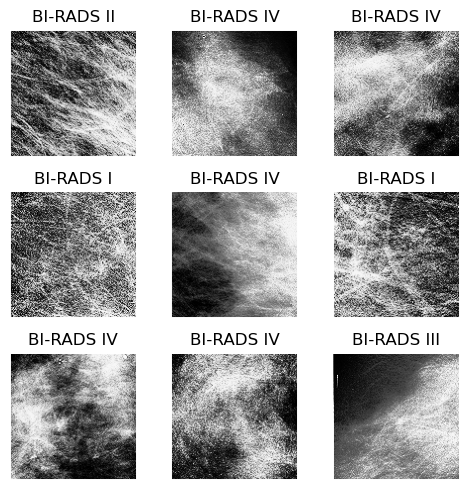

In [88]:
sample_images(dataloaders['train'], label_mapper=IrmaDataset.get_class_label, plot_borders=False)

In [89]:
for i in dataloaders['train']:
    print(i[0].shape)
    im = i[0][0]
    n_channels = im.shape[0]
    # npimg = np.asarray(im)
    min_val = torch.min(im)
    max_val = torch.max(im)
    print(min_val)
    print(max_val)
    # print(torch.histogram(torch.flatten(im[1]), bins=torch.tensor([*torch.unique(i[0][1], sorted=True), 1])))
    break

torch.Size([32, 1, 128, 128])
tensor(0.)
tensor(1.)


In [94]:
sb_res = results['sobel']

In [97]:
sb_res[0]['pvae']['pred_results']

(array([2, 3, 1, ..., 1, 2, 1], dtype=int64),
 array([3, 3, 1, ..., 0, 2, 3], dtype=int64))

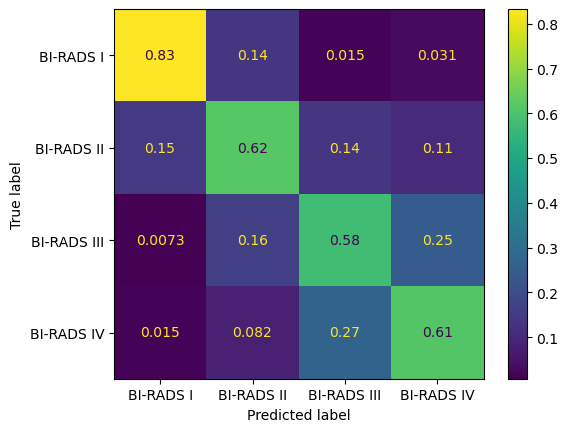

In [102]:
y_true = []
y_pred = []

for res in sb_res:
    y_true.extend(res['pvae']['pred_results'][1])
    y_pred.extend(res['pvae']['pred_results'][0])

cm = confusion_matrix(y_true, y_pred, normalize='pred')
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=IrmaDataset.irma_classmap.classes_
)
cm_display.plot()

In [109]:
res['pvae']['pred_results'][0]

array([0, 3, 1, ..., 2, 1, 2], dtype=int64)

In [106]:
[1 if r else 0 for r in res['pvae']['pred_results'][0] >= 2]
[1 if r else 0 for r in res['pvae']['pred_results'][1] >= 2]

[0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,


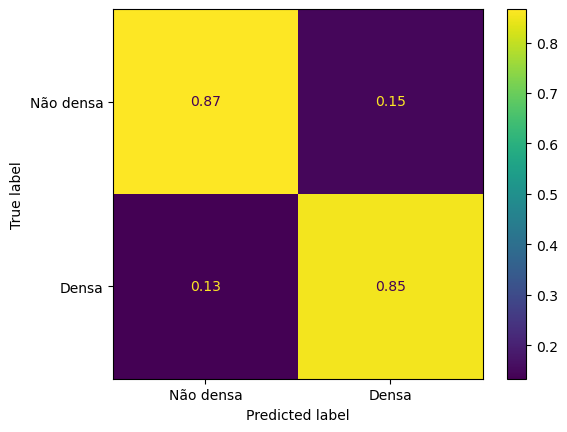

In [108]:
y_true = []
y_pred = []

for res in sb_res:
    y_true.extend([1 if r else 0 for r in res['pvae']['pred_results'][1] >= 2])
    y_pred.extend([1 if r else 0 for r in res['pvae']['pred_results'][0] >= 2])

cm = confusion_matrix(y_true, y_pred, normalize='pred')
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=['Não densa', 'Densa']
)
cm_display.plot()

In [92]:
sb_res

[{'vae': {'model': VAE(
     (encoder): Encoder(
       (conv): Sequential(
         (0): Conv2d(2, 192, kernel_size=(5, 5), stride=(1, 1))
         (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): GELU(approximate='none')
         (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (4): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1))
         (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (6): GELU(approximate='none')
         (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (8): Conv2d(128, 96, kernel_size=(3, 3), stride=(1, 1))
         (9): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (10): GELU(approximate='none')
         (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
         (12): Conv2d(96, 64, kernel_size=(3, 3), stride=(1

In [1]:
from sklearn.datasets import fetch_20newsgroups

In [2]:
fetch_20newsgroups()

{'data': ["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n",
  "From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Final call for SI clock reports\nKeywords: SI,acceleration,clock,upgrade\nArticle-I.D.: shelley.1qvfo9INNc3s\nOrganization: University of Washingto